# Trabajo Práctico N° 2 IA: Sistemas inteligentes


## 1. Importar librerias y cargar imagenes a utilizar


In [1]:
import os

import tensorflow as tf
import numpy as np
import xml.etree.ElementTree as ET
from google.colab import drive
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
base_path = 'gdrive/MyDrive/IA-TP'
training_path = base_path + '/images/Train'
test_path = base_path + '/images/Test'

## 2. Análisis de los datos a utilizar

En las carpetas **train** y **test** se encuentran imágenes de 770 x 600 de distintos jeroglíficos egipcios. Existen varias imagenes para un mismo jeroglífico, cada una de ellas con pequeñas variaciones en cuanto al ángulo o la posición. A continuación se muestran dos ejemplos:

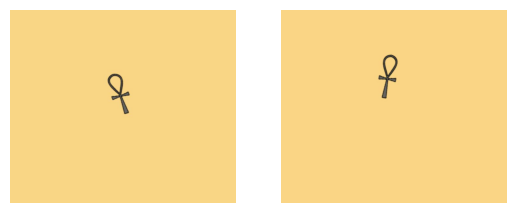

In [4]:
example_image_1 = Image.open(test_path + '/ankh (43).jpg')
example_image_2 = Image.open(test_path + '/ankh (47).jpg')

fig, axes = plt.subplots(1, 2)
axes[0].imshow(example_image_1)
axes[0].axis('off')
axes[1].imshow(example_image_2)
axes[1].axis('off')

plt.show()

El atributo objetivo (categoría del jeroglífico) se encuentra en un archivo XML que acompaña a cada imagen.
A su vez, este archivo incluye cuatro coordenadas que definen un Bounding Box (cuadro delimitador, en español), delimitando el área exacta de la imagen donde se encuentra el jeroglífico. Esto será muy util al preparar las imágenes, ya que como se ve en los ejemplos anteriores la mayor parte correspende al fondo, el cual no aporta información relevante para la clasificación.

# 3. Preparación de los datos
La preparación de los datos consistirá de los siguientes pasos:

1.   Recortar las imagenes de acuerdo al Bounding Box, como se explico en la sección anterior
2.   Redimensionar las imagenes, para que todas tengan el mismo tamaño, en este caso de 128 x 128 px
3.   Convertir las imagenes a una escala de grises, ya que los colores no son relevantes para la clasificación
4.   Transformar las imagenes en un vector y reescalar los valores en una escala entre 0 y 1
5.  Transformar el atributo objetivo de un "String" a un vector, utilizando el método de one-hot encoding
6.   Eliminar la categoría "Head" ya que solo hay imagenes de la misma en los datos de prueba. Además, la cantidad de ejemplos es muy baja (nueve en total), lo que nos impide tomar ejemplos de datos de prueba y utilizarlos como datos de entrenamiento


In [5]:
def process_image_and_name(image_path, xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    xmin = int(root.find('.//bndbox/xmin').text)
    ymin = int(root.find('.//bndbox/ymin').text)
    xmax = int(root.find('.//bndbox/xmax').text)
    ymax = int(root.find('.//bndbox/ymax').text)

    category = root.find('.//name').text

    image = Image.open(image_path)
    cropped_image = image.crop((xmin, ymin, xmax, ymax))
    resized_image = cropped_image.resize((128, 128))
    grayscale_image = resized_image.convert('L')
    normalized_image = np.array(grayscale_image) / 255.0

    return (normalized_image, category)

# Esto es bastante lento en collab, en lo posible leer de los archivos ya procesados
# El "quiet" esta para poder observar el progreso en caso de hacerlo en collab
def process_images_in_folder(folder_path, quiet=True):
    images = []
    categories = []
    for i, file in enumerate(os.listdir(folder_path)):
        if not quiet:
            print(f"Procesando {file} ({i+1}/{len(os.listdir(folder_path))})")
        if file.endswith('.jpg') and not file.startswith('head'):
            image_path = os.path.join(folder_path, file)
            xml_path = image_path.replace('.jpg', '.xml')
            if os.path.exists(xml_path):
                process_image_and_name(image_path, xml_path)
                image, category = process_image_and_name(image_path, xml_path)
                images.append(image)
                categories.append(category)
            elif not quiet:
                print(f"Saltando {file} ya que no se encontró el archivo XML correspondiente")
    return np.array(images), np.array(categories)

def get_one_hot_encoding(categories, category_to_int_map):
    vec = [category_to_int_map[category] for category in categories]
    return to_categorical(vec)

In [9]:
# Si no se cuenta con los archivos ya procesados
# Comentar las siguientes dos lineas y descomentar la ultima.
processed_test_images = np.load(base_path + "/datos-procesados/processed_test_images.npy")
processed_test_categories= np.load(base_path + "/datos-procesados/processed_test_categories.npy")
# processed_test_images, processed_test_categories= process_images_in_folder(test_path)

# Idem que el anterior
processed_training_images = np.load(base_path + "/datos-procesados/processed_training_images.npy")
processed_training_categories = np.load(base_path + "/datos-procesados/processed_training_categories.npy")
#processed_training_images, processed_training_categories = process_images_in_folder(training_path)

In [11]:
category_to_int_map = {category: index for index, category in enumerate(np.unique(processed_training_categories))}
encoded_test_categories = get_one_hot_encoding(processed_test_categories, category_to_int_map)
encoded_training_categories = get_one_hot_encoding(processed_training_categories, category_to_int_map)

## 4. Distribución de los datos

El set de datos utilizado ya contaba con la división entre datos de prueba y datos de entrenamiento, a continuación se muestra la información principal de cada uno.

In [12]:
training_quantity = len(processed_training_images)
test_quantity = len(processed_test_images)

print(f"Cantidad de datos totales: {training_quantity + test_quantity}")
print(f"Cantidad de datos de entrenamiento: {training_quantity}")
print(f"Porcentaje de datos de entrenamiento: {training_quantity / (training_quantity + test_quantity):.2%}")
print(f"Cantidad de datos de prueba: {test_quantity}")
print(f"Porcentaje de datos de prueba: {test_quantity / (training_quantity + test_quantity):.2%}")


training_category_counts = dict(zip(*np.unique(processed_training_categories, return_counts=True)))
test_category_counts = dict(zip(*np.unique(processed_test_categories, return_counts=True)))
category_count = len(training_category_counts.keys())
print(f"\nCantidad de categorías: {category_count}")
print(f"Cantidad de ejemplos por categoría en datos de entrenamiento: {training_category_counts}")
print(f"Cantidad de ejemplos por categoría en datos de prueba: {test_category_counts}")

Cantidad de datos totales: 4928
Cantidad de datos de entrenamiento: 3889
Porcentaje de datos de entrenamiento: 78.92%
Cantidad de datos de prueba: 1039
Porcentaje de datos de prueba: 21.08%

Cantidad de categorías: 95
Cantidad de ejemplos por categoría en datos de entrenamiento: {'100': 41, 'Among': 41, 'Angry': 41, 'Ankh': 41, 'Aroura': 41, 'At': 41, 'Bad_Thinking': 41, 'Bandage': 41, 'Bee': 41, 'Belongs': 41, 'Birth': 41, 'Board_Game': 41, 'Book': 41, 'Boy': 40, 'Branch': 41, 'Bread': 41, 'Brewer': 41, 'Builder': 41, 'Bury': 41, 'Canal': 41, 'Cloth_on_Pole': 41, 'Cobra': 41, 'Composite_Bow': 41, 'Cooked': 41, 'Corpse': 41, 'Dessert': 41, 'Divide': 41, 'Duck': 41, 'Elephant': 41, 'Enclosed_Mound': 41, 'Eye': 41, 'Fabric': 41, 'Face': 41, 'Falcon': 41, 'Fingre': 41, 'Fish': 41, 'Flail': 41, 'Folded_Cloth': 41, 'Foot': 41, 'Galena': 41, 'Giraffe': 40, 'He': 41, 'Her': 41, 'Hit': 40, 'Horn': 41, 'King': 41, 'Leg': 40, 'Length_Of_a_Human_Arm': 39, 'Life_Spirit': 41, 'Limit': 41, 'Lion': 4

Según lo pedido en el trabajo, el set de prueba debe contener al menos el 25% de los ejemplo totales. Para resolver este problema decidimos tomar 2 ejemplos al azar de cada categoría y moverlos a los datos de prueba. Esto nos permite obtener 190 nuevos ejemplos de prueba y no debería afectar en gran medida al entrenamiento

In [13]:
for category in range(category_count):
    indices_category = np.where(encoded_training_categories[:, category] == 1)[0]
    selected_indices = np.random.choice(indices_category, size=2, replace=False)

    processed_test_images = np.vstack((processed_test_images, processed_training_images[selected_indices]))
    encoded_test_categories = np.vstack((encoded_test_categories, encoded_training_categories[selected_indices]))

    processed_training_images = np.delete(processed_training_images, selected_indices, axis=0)
    encoded_training_categories = np.delete(encoded_training_categories, selected_indices, axis=0)


Una vez realizado esto el porcentaje aumenta hasta un 24.94%

In [14]:
training_quantity = len(processed_training_images)
test_quantity = len(processed_test_images)

print(f"Cantidad de datos totales: {training_quantity + test_quantity}")
print(f"Cantidad de datos de entrenamiento: {training_quantity}")
print(f"Porcentaje de datos de entrenamiento: {training_quantity / (training_quantity + test_quantity):.2%}")
print(f"Cantidad de datos de prueba: {test_quantity}")
print(f"Porcentaje de datos de prueba: {test_quantity / (training_quantity + test_quantity):.2%}")

Cantidad de datos totales: 4928
Cantidad de datos de entrenamiento: 3699
Porcentaje de datos de entrenamiento: 75.06%
Cantidad de datos de prueba: 1229
Porcentaje de datos de prueba: 24.94%


El último paso a realizar en cuanto a la distribución de los datos es crear un set de validación. Para esto utilizaremos la funcion train_test_split de la libreria scikit-learn, separando un 10% de los datos de entrenamiento disponibles. Está función, a su vez, nos permite mezclar de forma aleatoria los valores, algo muy util ya que los datos originales se encontraban ordenados, lo que podría originar algunos problemas al entrenar la red nueronal

In [15]:
x_train, x_validation, y_train, y_validation = train_test_split(processed_training_images,
                                                              encoded_training_categories,
                                                              test_size=0.1, shuffle=True)

#Esto lo hago para mantener la convencion de nombres
x_test, y_test = processed_test_images, encoded_test_categories


In [59]:
data = [len(x_train), len(x_validation), len(x_test)]
labels = ['Entrenamiento', 'Validación', 'Prueba']
total = sum(data)

print(f"Cantidad de datos totales: {total}")
print(f"Cantidad de datos de entrenamiento: {data[0]}")
print(f"Cantidad de datos de validación: {data[1]}")
print(f"Cantidad de datos de prueba: {data[2]}")

Cantidad de datos totales: 4928
Cantidad de datos de entrenamiento: 3329
Cantidad de datos de validación: 370
Cantidad de datos de prueba: 1229


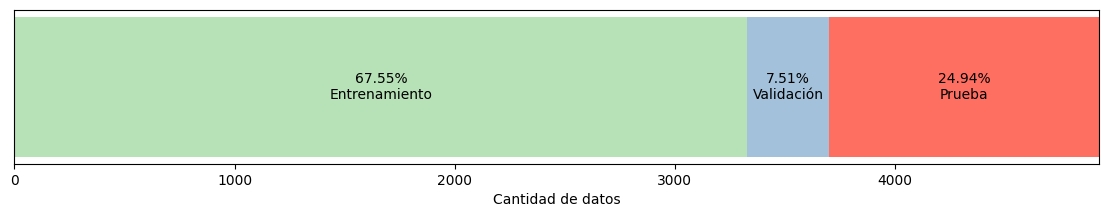

In [17]:
colors = ["#B7E1B7", "#A3C1DA", "#FF6F61"]

plt.figure(figsize=(14, 2))
plt.xlabel("Cantidad de datos")
plt.xlim(0,total)

plt.barh([0], data[0], color=colors[0])
plt.barh([0], data[1], left=data[0], color=colors[1])
plt.barh([0], data[2], left=data[0] + data[1], color=colors[2])

plt.yticks([])

aux = 0
for label, value in zip(labels, data):
    percentage = value / total
    text = f"{percentage:.2%}\n{label}"
    plt.text(aux + value/2, 0, text, va="center", ha="center")
    aux += value

plt.show()


## 5. Definición de la Red y Entrenamiento


In [ ]:
def plot_training_history(history, figsize):
    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Gráfico del Error del Entrenamiento')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    plt.show()

    plt.figure(figsize=figsize)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Gráfico de la Exactitud del Entrenamiento')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    plt.show()

def show_model_summary(model):
    model.summary()
    print("\n")
    plot_model(model, show_layer_names=True, show_shapes=True)

In [56]:
def build_model():
    inputs = tf.keras.Input(shape=(128, 128, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(128, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(95, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [57]:
model = build_model()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [58]:
history = model.fit(x_train, y_train, epochs=100,
                    validation_data=(x_validation, y_validation),
                    callbacks=[early_stopping])

Epoch 1/100
105/105 [==============================] - 11s 93ms/step - loss: 4.4606 - accuracy: 0.0234 - val_loss: 4.0925 - val_accuracy: 0.0919
Epoch 2/100
105/105 [==============================] - 10s 91ms/step - loss: 3.5855 - accuracy: 0.1451 - val_loss: 3.0877 - val_accuracy: 0.2351
Epoch 3/100
105/105 [==============================] - 10s 92ms/step - loss: 2.4709 - accuracy: 0.3364 - val_loss: 1.5852 - val_accuracy: 0.6432
Epoch 4/100
105/105 [==============================] - 10s 93ms/step - loss: 1.6922 - accuracy: 0.5176 - val_loss: 1.1621 - val_accuracy: 0.6676
Epoch 5/100
105/105 [==============================] - 10s 91ms/step - loss: 1.2928 - accuracy: 0.6173 - val_loss: 0.9500 - val_accuracy: 0.7405
Epoch 6/100
105/105 [==============================] - 9s 90ms/step - loss: 1.0005 - accuracy: 0.7038 - val_loss: 0.6399 - val_accuracy: 0.8243
Epoch 7/100
105/105 [==============================] - 9s 89ms/step - loss: 0.7937 - accuracy: 0.7591 - val_loss: 0.6758 - val_accu

In [60]:
model.evaluate(x_test, y_test)

39/39 [==============================] - 1s 25ms/step - loss: 0.3012 - accuracy: 0.9227


[0.30116674304008484, 0.922701358795166]

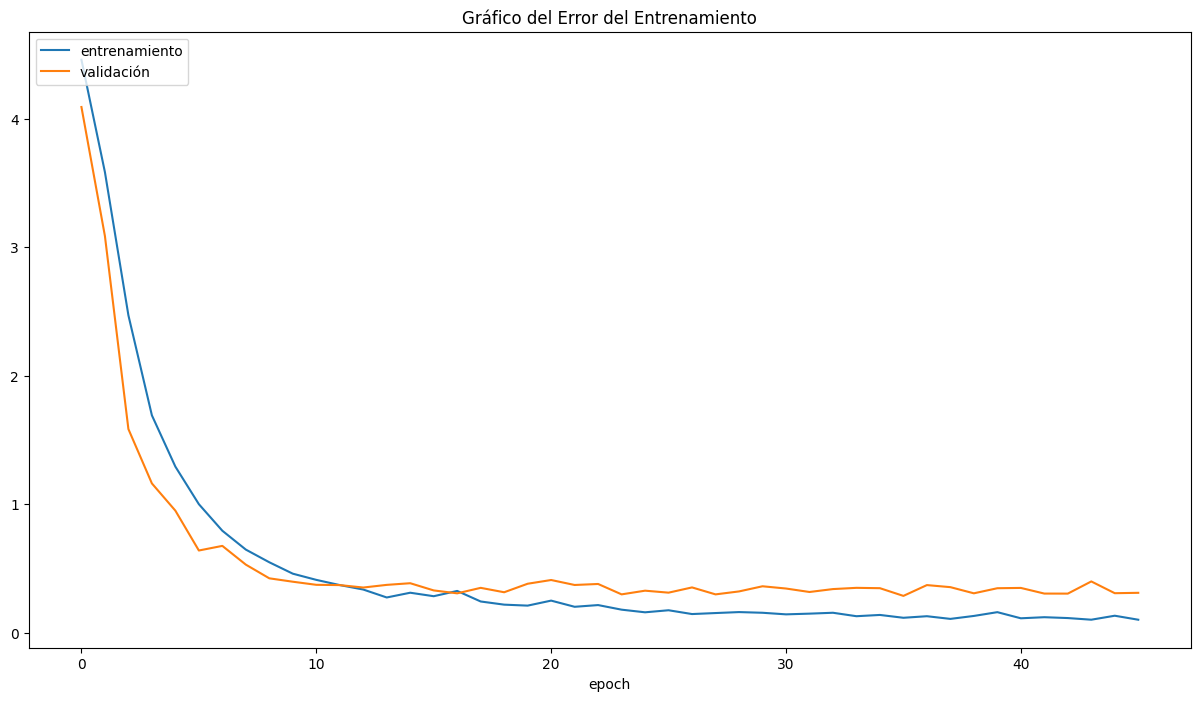

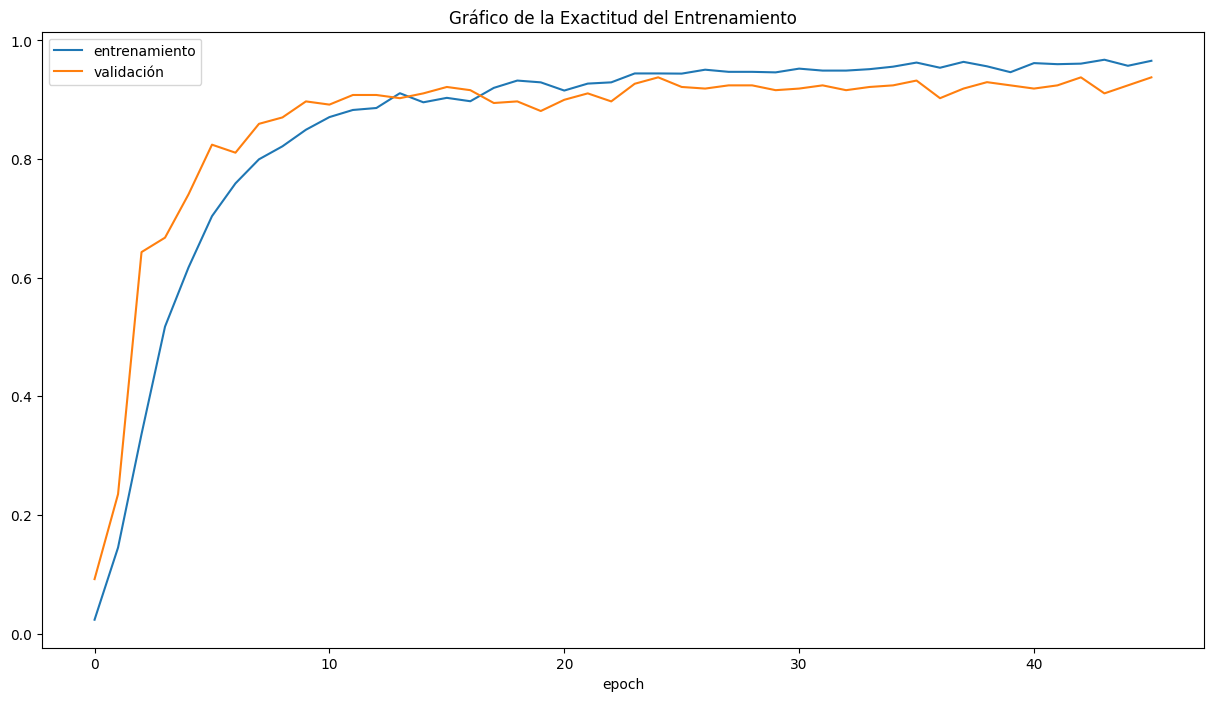

In [61]:
plot_training_history(history, (12,8))